# Libraries

In [10]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.automl import H2OAutoML
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')

In [11]:
pd.set_option('display.max_columns', None)

# Data

## Intake data

### Data url

In [12]:
intake_url = "https://data.austintexas.gov/resource/wter-evkm.csv?$limit=500000"

### Data pull

In [13]:
df_intakes = pd.read_csv(intake_url)

### Data preview

In [14]:
df_intakes.head()

,animal_id,name,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color
0,A521520,Nina,2013-10-01T07:51:00.000,2013-10-01T07:51:00.000,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan
1,A664235,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2,A664236,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
3,A664237,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
4,A664233,Stevie,2013-10-01T08:53:00.000,2013-10-01T08:53:00.000,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White


## Outcome data

### Data url

In [15]:
outcome_url = "https://data.austintexas.gov/resource/9t4d-g238.csv?$limit=500000"

### Data pull

In [16]:
df_outcomes = pd.read_csv(outcome_url)

### Data preview

In [17]:
df_outcomes.head(20)

,animal_id,date_of_birth,name,datetime,monthyear,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A668305,2012-12-01,NaN,2013-12-02T00:00:00-05:00,12-2013,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Brown/Yellow
1,A673335,2012-02-22,NaN,2014-02-22T00:00:00-05:00,02-2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon,Black/Gray
2,A675999,2013-04-03,NaN,2014-04-07T00:00:00-05:00,04-2014,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Green
3,A679066,2014-04-16,NaN,2014-05-16T00:00:00-05:00,05-2014,NaN,NaN,Other,Unknown,4 weeks,Rabbit Sh,Brown
4,A680855,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
5,A680857,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
6,A680858,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
7,A680859,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
8,A680860,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black
9,A680861,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black


# EDA

## Missing values in intakes

In [18]:
# Check for missing values in df_outcomes
missing_values = df_intakes.isnull().sum()
print("Missing values in df_intakes:\n", missing_values)

Missing values in df_intakes:
 animal_id               0
name                49991
datetime                0
datetime2               0
found_location          0
intake_type             0
intake_condition        0
animal_type             0
sex_upon_intake         1
age_upon_intake         0
breed                   0
color                   0
dtype: int64


## Missing values in outcomes

In [19]:
# Check for missing values in df_outcomes
missing_values = df_outcomes.isnull().sum()
print("Missing values in df_outcomes:\n", missing_values)

Missing values in df_outcomes:
 animal_id               0
date_of_birth           0
name                49784
datetime                0
monthyear               0
outcome_type           46
outcome_subtype     94115
animal_type             0
sex_upon_outcome        1
age_upon_outcome        9
breed                   0
color                   0
dtype: int64


## Unique values in color

In [20]:
df_intakes['color'].nunique()

661

In [21]:
df_outcomes['color'].nunique()

663

High cardinality exists here

## Unique values in found_location

In [22]:
df_intakes['found_location'].nunique()

70183

High cardinality exists here

## Unique values in breed

In [23]:
df_intakes['breed'].nunique()

3006

In [24]:
df_outcomes['breed'].nunique()

3010

High cardinality here too

# Preprocessing

## Fix datetime column

### Intakes

In [25]:
df_intakes['datetime'] = pd.to_datetime(df_intakes['datetime'])

In [26]:
df_intakes['monthyear'] = pd.to_datetime(df_intakes['datetime2']).dt.strftime('%m-%Y')

In [27]:
df_intakes = df_intakes.drop(columns=['datetime2'])

### Outcomes

In [28]:
df_outcomes['date_of_birth'] = pd.to_datetime(df_outcomes['date_of_birth'])
df_outcomes['monthyear'] = pd.to_datetime(df_outcomes['monthyear'], format='%m-%Y')

In [29]:
df_outcomes['datetime'] = pd.to_datetime(df_outcomes['datetime'], format='mixed', utc=True)

## Dropping null values from both dataframes

For **df_intakes**, missing names can be handled later in a binary variable, while, variables like *sex_upon_intake* will need to be omitted from the analysis.

For **df_outcomes**, missing values in age and sex will be omitted. 

In [30]:
df_intakes = df_intakes.dropna(subset=['sex_upon_intake'])

In [31]:
df_outcomes = df_outcomes.dropna(subset=['outcome_type', 'sex_upon_outcome', 'age_upon_outcome'])

## Combining both dataframes into one

### First, sort by date

In [32]:
df_intakes_sorted = df_intakes.sort_values('datetime')
df_outcomes_sorted = df_outcomes.sort_values('datetime')

### Combine both dataframes into one

In [33]:
combined_df = pd.merge(df_intakes_sorted, df_outcomes_sorted, on='animal_id', suffixes=('_intake', '_outcome'), how='inner')

## Age variable fix

In [34]:
def convert_age_to_days(age_str, name_str=None):
    """Convert age string to numeric days"""
    if pd.isna(age_str):
        return None
    
    age_str = age_str.lower()
    
    # Handle "0 years" case - check if newborn based on name containing "grams"
    if age_str.strip() == "0 years":
        if name_str and "grams" in str(name_str).lower():
            return 0  # Newborn
        else:
            return None  # Missing age data
    
    total_days = 0
    
    # Find all number-unit pairs
    patterns = [
        (r'(\d+)\s*year', 365),
        (r'(\d+)\s*month', 30),
        (r'(\d+)\s*week', 7),
        (r'(\d+)\s*day', 1)
    ]
    
    for pattern, multiplier in patterns:
        matches = re.findall(pattern, age_str)
        for match in matches:
            total_days += int(match) * multiplier
    
    return total_days if total_days > 0 else None

def convert_age_to_years(age_str, name_str=None):
    """Convert age string to numeric years (decimal)"""
    days = convert_age_to_days(age_str, name_str)
    return days / 365 if days is not None else None

In [35]:
df_intakes['age_upon_intake_days'] = df_intakes.apply(lambda row: convert_age_to_days(row['age_upon_intake'], row.get('name')), axis=1)
df_intakes['age_upon_intake_years'] = df_intakes.apply(lambda row: convert_age_to_years(row['age_upon_intake'], row.get('name')), axis=1)

df_outcomes['age_upon_outcome_days'] = df_outcomes.apply(lambda row: convert_age_to_days(row['age_upon_outcome'], row.get('name')), axis=1)
df_outcomes['age_upon_outcome_years'] = df_outcomes.apply(lambda row: convert_age_to_years(row['age_upon_outcome'], row.get('name')), axis=1)


In [36]:
print("Sample conversions:")
test_ages = ["7 years", "2 weeks", "5 months", "10 days"]
for age in test_ages:
    print(f"{age} -> {convert_age_to_days(age)} days, {convert_age_to_years(age):.2f} years")

Sample conversions:
7 years -> 2555 days, 7.00 years
2 weeks -> 14 days, 0.04 years
5 months -> 150 days, 0.41 years
10 days -> 10 days, 0.03 years


In [37]:
combined_df['age_upon_outcome_days'] = combined_df.apply(lambda row: convert_age_to_days(row['age_upon_outcome'], row.get('name')), axis=1)
combined_df['age_upon_outcome_years'] = combined_df.apply(lambda row: convert_age_to_years(row['age_upon_outcome'], row.get('name')), axis=1)

combined_df['age_upon_intake_days'] = combined_df.apply(lambda row: convert_age_to_days(row['age_upon_intake'], row.get('name')), axis=1)
combined_df['age_upon_intake_years'] = combined_df.apply(lambda row: convert_age_to_years(row['age_upon_intake'], row.get('name')), axis=1)

In [38]:
combined_df.isna().sum()

animal_id                      0
name_intake                50645
datetime_intake                0
found_location                 0
intake_type                    0
intake_condition               0
animal_type_intake             0
sex_upon_intake                0
age_upon_intake                0
breed_intake                   0
color_intake                   0
monthyear_intake               0
date_of_birth                  0
name_outcome               50645
datetime_outcome               0
monthyear_outcome              0
outcome_type                   0
outcome_subtype           133819
animal_type_outcome            0
sex_upon_outcome               0
age_upon_outcome               0
breed_outcome                  0
color_outcome                  0
age_upon_outcome_days        283
age_upon_outcome_years       283
age_upon_intake_days        1284
age_upon_intake_years       1284
dtype: int64

In [39]:
df_outcomes.isna().sum()

animal_id                     0
date_of_birth                 0
name                      49759
datetime                      0
monthyear                     0
outcome_type                  0
outcome_subtype           94070
animal_type                   0
sex_upon_outcome              0
age_upon_outcome              0
breed                         0
color                         0
age_upon_outcome_days       248
age_upon_outcome_years      248
dtype: int64

In [40]:
df_intakes.isnull().sum()

animal_id                    0
name                     49991
datetime                     0
found_location               0
intake_type                  0
intake_condition             0
animal_type                  0
sex_upon_intake              0
age_upon_intake              0
breed                        0
color                        0
monthyear                    0
age_upon_intake_days      1236
age_upon_intake_years     1236
dtype: int64

### Dropping null values for age upon intake & age upon outcome

In [41]:
df_intakes = df_intakes.dropna(subset=['age_upon_intake_days'])

In [42]:
df_outcomes = df_outcomes.dropna(subset=['age_upon_outcome_days'])

### Dropping age upon intake and age upon outcome columns

In [43]:
df_intakes = df_intakes.drop(columns=['age_upon_intake'])
df_outcomes = df_outcomes.drop(columns=['age_upon_outcome'])

In [44]:
# Null values in 

# 1. Check for null values in the dataset
print(df_intakes.isnull().sum())

# 2. Check for null values in the dataset
print(df_outcomes.isnull().sum())

animal_id                    0
name                     49225
datetime                     0
found_location               0
intake_type                  0
intake_condition             0
animal_type                  0
sex_upon_intake              0
breed                        0
color                        0
monthyear                    0
age_upon_intake_days         0
age_upon_intake_years        0
dtype: int64
animal_id                     0
date_of_birth                 0
name                      49564
datetime                      0
monthyear                     0
outcome_type                  0
outcome_subtype           94050
animal_type                   0
sex_upon_outcome              0
breed                         0
color                         0
age_upon_outcome_days         0
age_upon_outcome_years        0
dtype: int64


## Breed variable fix

In [45]:
def engineer_breed_features(df, breed_column='breed'):
    """Extract meaningful features from breed information"""
    
    # Create a copy to avoid modifying original
    df = df.copy()
    
    # Animal type already exists, so skipping that classification
    
    # Mixed breed indicators
    df['is_mixed'] = df[breed_column].str.contains('Mix|/', case=False, na=False)
    df['num_breeds'] = df[breed_column].str.count('/') + 1
    df['num_breeds'] = df['num_breeds'].where(df['is_mixed'], 1)
    
    # Size categories (based on common breed patterns)
    toy_breeds = ['Chihuahua', 'Yorkshire', 'Toy', 'Maltese', 'Pomeranian', 'Papillon', 'Miniature']
    small_breeds = ['Terrier', 'Beagle', 'Cocker', 'Dachshund', 'Corgi', 'Pug', 'Shih Tzu']
    large_breeds = ['Retriever', 'Shepherd', 'Mastiff', 'Great Dane', 'Rottweiler', 'Great Pyrenees', 'Newfoundland']
    
    def categorize_size(breed_str):
        if pd.isna(breed_str):
            return 'Unknown'
        breed_str = str(breed_str)
        if any(toy in breed_str for toy in toy_breeds):
            return 'Toy'
        elif any(large in breed_str for large in large_breeds):
            return 'Large'
        elif any(small in breed_str for small in small_breeds):
            return 'Small'
        else:
            return 'Medium'
    
    df['size_category'] = df[breed_column].apply(categorize_size)
    
    # Working/sport groups
    working_breeds = ['Shepherd', 'Cattle Dog', 'Border Collie', 'Australian Kelpie', 'Husky', 'Malamute']
    sporting_breeds = ['Retriever', 'Pointer', 'Spaniel', 'Setter', 'Vizsla']
    terrier_breeds = ['Terrier']
    
    df['is_working'] = df[breed_column].str.contains('|'.join(working_breeds), case=False, na=False)
    df['is_sporting'] = df[breed_column].str.contains('|'.join(sporting_breeds), case=False, na=False)
    df['is_terrier'] = df[breed_column].str.contains('Terrier', case=False, na=False)
    
    # Popular breed indicators
    popular_dog_breeds = ['Labrador', 'Golden Retriever', 'Pit Bull', 'Chihuahua', 'Beagle', 'German Shepherd']
    popular_cat_breeds = ['Domestic Shorthair', 'Domestic Longhair', 'Siamese']
    
    df['is_popular_dog'] = df[breed_column].str.contains('|'.join(popular_dog_breeds), case=False, na=False)
    df['is_popular_cat'] = df[breed_column].str.contains('|'.join(popular_cat_breeds), case=False, na=False)
    
    # Exotic/unusual animals
    exotic_animals = ['Snake', 'Lizard', 'Turtle', 'Bird', 'Rabbit', 'Ferret', 'Pig', 'Goat', 'Chicken']
    df['is_exotic'] = df[breed_column].str.contains('|'.join(exotic_animals), case=False, na=False)
    
    # Primary breed (for mixed breeds, take the first one)
    def extract_primary_breed(breed_str):
        if pd.isna(breed_str):
            return None
        breed_str = str(breed_str)
        if '/' in breed_str:
            return breed_str.split('/')[0].strip()
        elif 'Mix' in breed_str:
            return breed_str.replace(' Mix', '').strip()
        else:
            return breed_str.strip()
    
    df['primary_breed'] = df[breed_column].apply(extract_primary_breed)
    
    # Breed complexity score (more complex = more mixed)
    df['breed_complexity'] = df['num_breeds'] + df['is_mixed'].astype(int)
    
    return df

In [46]:
combined_df = engineer_breed_features(combined_df, 'breed_outcome')

In [47]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221168 entries, 0 to 221167
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   animal_id               221168 non-null  object             
 1   name_intake             170523 non-null  object             
 2   datetime_intake         221168 non-null  datetime64[ns]     
 3   found_location          221168 non-null  object             
 4   intake_type             221168 non-null  object             
 5   intake_condition        221168 non-null  object             
 6   animal_type_intake      221168 non-null  object             
 7   sex_upon_intake         221168 non-null  object             
 8   age_upon_intake         221168 non-null  object             
 9   breed_intake            221168 non-null  object             
 10  color_intake            221168 non-null  object             
 11  monthyear_intake        22

In [48]:
combined_df = combined_df.drop(columns=['breed_intake','breed_outcome'])

## Has name column

### Fix cases with weight in place of name

Some newborn animals have their weight put into the name column. Let's fix this

In [49]:
# Replace weight entries with null values
combined_df['name_intake'] = combined_df['name_intake'].replace(r'^\d+\s*grams?$', pd.NA, regex=True)
combined_df['name_outcome'] = combined_df['name_outcome'].replace(r'^\d+\s*grams?$', pd.NA, regex=True)

### If name at outcome is not null, has_name will be 1, 0 otherwise

In [50]:
combined_df['has_name'] = combined_df['name_outcome'].notnull().astype(int)

## Keeping only Dogs and Cats

Less than 6% if instances are not dogs or cats. Thus, for this model, dropping those instances makes sense.

In [51]:
combined_df = combined_df[combined_df['animal_type_outcome'].isin(['Dog', 'Cat'])]

## Fix found_location column to extract feature

The good thing here is that the location an animal is found is noted down, but, due to high cardinality, this feature also needs to be engineered. Capturing the jurisdiction, and area related information is going to be engineered.

In [52]:
def engineer_location_features(df, location_column='found_location'):
    """Extract meaningful features from found_location"""
    
    df = df.copy()
    
    # Extract jurisdiction/city from parentheses or end of string
    def extract_jurisdiction(location_str):
        if pd.isna(location_str):
            return None
        location_str = str(location_str).strip()
        
        # Pattern for (TX) or (County)
        paren_match = re.search(r'\(([^)]+)\)', location_str)
        if paren_match:
            return paren_match.group(1)
        
        # For cases like "Manor(TX)" without space
        no_space_match = re.search(r'([A-Za-z]+)\([^)]+\)$', location_str)
        if no_space_match:
            return no_space_match.group(1)
        
        return None
    
    # Extract city/area name
    def extract_city(location_str):
        if pd.isna(location_str):
            return None
        location_str = str(location_str).strip()
        
        # Handle "Outside jurisdiction"
        if 'outside jurisdiction' in location_str.lower():
            return 'Outside Jurisdiction'
        
        # Extract city before " in " or before parentheses
        if ' in ' in location_str:
            parts = location_str.split(' in ')
            if len(parts) > 1:
                city_part = parts[1].split('(')[0].strip()
                return city_part
        
        # For direct formats like "Austin (TX)" or "Manor(TX)"
        city_match = re.search(r'^([A-Za-z\s]+)(?:\s*\(|$)', location_str)
        if city_match:
            return city_match.group(1).strip()
        
        return location_str
    
    # Apply extractions
    df['jurisdiction'] = df[location_column].apply(extract_jurisdiction)
    df['city_area'] = df[location_column].apply(extract_city)
    
    # Austin area classifications
    austin_areas = ['Austin', 'Travis', 'Manor', 'Pflugerville', 'Cedar Park', 'Round Rock', 
                   'Lakeway', 'Bee Cave', 'West Lake Hills', 'Rollingwood', 'Sunset Valley']
    
    surrounding_areas = ['Williamson', 'Hays', 'Bastrop', 'Caldwell', 'Georgetown', 
                        'Leander', 'Cedar Creek', 'Elgin', 'Dripping Springs']
    
    df['is_austin_metro'] = df['city_area'].isin(austin_areas)
    df['is_surrounding_area'] = df['city_area'].isin(surrounding_areas)
    df['is_outside_jurisdiction'] = df['city_area'] == 'Outside Jurisdiction'
    
    # Core Austin vs suburbs
    df['is_core_austin'] = df['city_area'] == 'Austin'
    df['is_travis_county'] = df['city_area'].isin(['Austin', 'Travis', 'Manor'])
    
    # Distance categories (approximate)
    def categorize_distance(city):
        if pd.isna(city):
            return 'Unknown'
        if city in ['Austin', 'Travis']:
            return 'Core'
        elif city in ['Manor', 'Pflugerville', 'West Lake Hills', 'Rollingwood', 'Sunset Valley']:
            return 'Close Suburbs'
        elif city in ['Cedar Park', 'Round Rock', 'Lakeway', 'Bee Cave']:
            return 'Far Suburbs'
        elif city == 'Outside Jurisdiction':
            return 'Outside'
        else:
            return 'Other'
    
    df['distance_category'] = df['city_area'].apply(categorize_distance)
    
    # Has specific address (contains street info)
    # df['has_address_detail'] = df[location_column].str.contains(r'\d+\s+\w+', na=False)
    
    return df

In [53]:
combined_df = engineer_location_features(combined_df, 'found_location')

In [54]:
def print_location_summary(df):
    """Print summary of location features"""
    print("Location Feature Summary:")
    print(f"Core Austin: {df['is_core_austin'].sum()}")
    print(f"Travis County: {df['is_travis_county'].sum()}")
    print(f"Austin Metro: {df['is_austin_metro'].sum()}")
    print(f"Outside Jurisdiction: {df['is_outside_jurisdiction'].sum()}")
    print("\nDistance categories:")
    print(df['distance_category'].value_counts())

In [55]:
print_location_summary(combined_df)

Location Feature Summary:
Core Austin: 172768
Travis County: 199144
Austin Metro: 202672
Outside Jurisdiction: 3996

Distance categories:
distance_category
Core             195052
Close Suburbs      6814
Other              4560
Outside            3996
Far Suburbs         806
Name: count, dtype: int64


## Duplicate case fix

Duplicates for animal IDs exist because some animals keep returning, and, there are features here to capture these intricacies.

In [56]:
# Return visit feature engineering for combined dataframe
combined_df = combined_df.sort_values(['animal_id', 'datetime_intake'])

# Visit count for each animal
combined_df['visit_count'] = combined_df.groupby('animal_id').cumcount() + 1

# Return visit indicators
combined_df['is_return_visit'] = (combined_df['visit_count'] > 1).astype(int)
combined_df['is_frequent_returner'] = (combined_df['visit_count'] > 2).astype(int)

# Days since last visit
combined_df['days_since_last_visit'] = combined_df.groupby('animal_id')['datetime_intake'].diff().dt.days
combined_df['days_since_last_visit'] = combined_df['days_since_last_visit'].fillna(-1)

# Previous outcome type
combined_df['previous_outcome_type'] = combined_df.groupby('animal_id')['outcome_type'].shift(1)
combined_df['previous_outcome_type'] = combined_df['previous_outcome_type'].fillna('First Visit')

In [57]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211228 entries, 8344 to 221167
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   animal_id                211228 non-null  object             
 1   name_intake              168607 non-null  object             
 2   datetime_intake          211228 non-null  datetime64[ns]     
 3   found_location           211228 non-null  object             
 4   intake_type              211228 non-null  object             
 5   intake_condition         211228 non-null  object             
 6   animal_type_intake       211228 non-null  object             
 7   sex_upon_intake          211228 non-null  object             
 8   age_upon_intake          211228 non-null  object             
 9   color_intake             211228 non-null  object             
 10  monthyear_intake         211228 non-null  object             
 11  date_of_birth  

## High cardinality check

Some columns have high cardinalities, thus, depending on their importance, they will either be trasnformed, or dropped.

These columns are:

1. name_intake: drop
2. name_outcome: drop
3. color_intake: drop
4. color_outcome: drop
5. primary_breed: reduce/drop
6. monthyear_intake: split
7. age_upon_outcome: drop
8. age_upon_intake: drop
9. outcome_type: reduce to adoption or no adoption later
10. found_location: drop
11. city_area: reduce
12. outcome_subtype: drop
13. animal_id: drop before analysis
14. monthyear_outcome: split
15. jurisdiction: reduce

In [58]:
cat_cols = combined_df.select_dtypes(include=['object', 'category']).columns
cat_unique_counts = combined_df[cat_cols].nunique()
print(cat_unique_counts.sort_values(ascending=False))

animal_id                145572
found_location            64882
name_outcome              29080
name_intake               29080
color_intake                623
color_outcome               623
primary_breed               255
monthyear_intake            140
age_upon_outcome             51
age_upon_intake              51
city_area                    28
outcome_subtype              26
jurisdiction                 22
intake_condition             20
outcome_type                 11
previous_outcome_type        10
intake_type                   6
sex_upon_outcome              5
sex_upon_intake               5
distance_category             5
size_category                 4
animal_type_outcome           2
animal_type_intake            2
dtype: int64


In [59]:
# 1. Drop columns
columns_to_drop = ['name_intake', 'name_outcome', 'color_intake', 'color_outcome', 
                   'age_upon_outcome', 'age_upon_intake', 'found_location', 
                   'outcome_subtype', 'animal_id']
combined_df = combined_df.drop(columns=columns_to_drop)

# 2. Reduce primary_breed to top 10
top_breeds = combined_df['primary_breed'].value_counts().head(10).index
combined_df['primary_breed'] = combined_df['primary_breed'].apply(
    lambda x: x if x in top_breeds else 'Other'
)

# 3. Extract month from monthyear_intake
combined_df['month_intake'] = pd.to_datetime(combined_df['monthyear_intake']).dt.month
combined_df = combined_df.drop(columns=['monthyear_intake'])

# 4. Extract month from monthyear_outcome  
combined_df['month_outcome'] = pd.to_datetime(combined_df['monthyear_outcome']).dt.month
combined_df = combined_df.drop(columns=['monthyear_outcome'])

# 5. Reduce city_area to top 10
top_cities = combined_df['city_area'].value_counts().head(10).index
combined_df['city_area'] = combined_df['city_area'].apply(
    lambda x: x if x in top_cities else 'Other'
)

# 6. Reduce jurisdiction to top 10
top_jurisdictions = combined_df['jurisdiction'].value_counts().head(10).index
combined_df['jurisdiction'] = combined_df['jurisdiction'].apply(
    lambda x: x if x in top_jurisdictions else 'Other'
)

## Create target variable **Is_Adopted**

In [60]:
combined_df['outcome_type'].value_counts()

outcome_type
Adoption           107588
Transfer            51519
Return to Owner     42799
Euthanasia           5223
Rto-Adopt            2238
Died                 1453
Disposal              272
Missing               115
Stolen                 12
Relocate                8
Lost                    1
Name: count, dtype: int64

There will be a good class balance doing this, something the Long Beach struggled with. Albeit, this is a simpler analysis.

In [61]:
combined_df['Is_adopted'] = (combined_df['outcome_type'] == 'Adoption').astype(int)

In [62]:
combined_df = combined_df.drop(columns=['outcome_type'])

## Deconstructing time related features

Since datetime data types don't give enough interpretable information to the ML algorithm, understanding cyclical and temporal patterns would be better to identify with datetime transformations.

In [63]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211228 entries, 8344 to 221167
Data columns (total 41 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   datetime_intake          211228 non-null  datetime64[ns]     
 1   intake_type              211228 non-null  object             
 2   intake_condition         211228 non-null  object             
 3   animal_type_intake       211228 non-null  object             
 4   sex_upon_intake          211228 non-null  object             
 5   date_of_birth            211228 non-null  datetime64[ns]     
 6   datetime_outcome         211228 non-null  datetime64[ns, UTC]
 7   animal_type_outcome      211228 non-null  object             
 8   sex_upon_outcome         211228 non-null  object             
 9   age_upon_outcome_days    210973 non-null  float64            
 10  age_upon_outcome_years   210973 non-null  float64            
 11  age_upon_intake

### Extract Basic Time Components

In [64]:
# For datetime_intake
combined_df['intake_year'] = combined_df['datetime_intake'].dt.year
combined_df['intake_day'] = combined_df['datetime_intake'].dt.day
combined_df['intake_dayofweek'] = combined_df['datetime_intake'].dt.dayofweek

# For date_of_birth
combined_df['birth_year'] = combined_df['date_of_birth'].dt.year
combined_df['birth_month'] = combined_df['date_of_birth'].dt.month

### Seasonal Features

In [65]:
# Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)
combined_df['intake_season'] = combined_df['month_intake'].map({
    12: 1, 1: 1, 2: 1,    # Winter
    3: 2, 4: 2, 5: 2,     # Spring
    6: 3, 7: 3, 8: 3,     # Summer
    9: 4, 10: 4, 11: 4    # Fall
})

# Is weekend
combined_df['intake_is_weekend'] = (combined_df['intake_dayofweek'] >= 5).astype(int)

In [66]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211228 entries, 8344 to 221167
Data columns (total 48 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   datetime_intake          211228 non-null  datetime64[ns]     
 1   intake_type              211228 non-null  object             
 2   intake_condition         211228 non-null  object             
 3   animal_type_intake       211228 non-null  object             
 4   sex_upon_intake          211228 non-null  object             
 5   date_of_birth            211228 non-null  datetime64[ns]     
 6   datetime_outcome         211228 non-null  datetime64[ns, UTC]
 7   animal_type_outcome      211228 non-null  object             
 8   sex_upon_outcome         211228 non-null  object             
 9   age_upon_outcome_days    210973 non-null  float64            
 10  age_upon_outcome_years   210973 non-null  float64            
 11  age_upon_intake

## Removing all other outcome related information

Steps taken to prevent data leakage. Some other repetitive columns will also be dropped here.

In [67]:
combined_df = combined_df.drop(columns=['age_upon_outcome_days', 'age_upon_outcome_years', 'age_upon_intake_years', 'month_outcome', 'datetime_outcome', 'animal_type_outcome', 'sex_upon_outcome', 'datetime_intake'])

In [68]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211228 entries, 8344 to 221167
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   intake_type              211228 non-null  object        
 1   intake_condition         211228 non-null  object        
 2   animal_type_intake       211228 non-null  object        
 3   sex_upon_intake          211228 non-null  object        
 4   date_of_birth            211228 non-null  datetime64[ns]
 5   age_upon_intake_days     210014 non-null  float64       
 6   is_mixed                 211228 non-null  bool          
 7   num_breeds               211228 non-null  int64         
 8   size_category            211228 non-null  object        
 9   is_working               211228 non-null  bool          
 10  is_sporting              211228 non-null  bool          
 11  is_terrier               211228 non-null  bool          
 12  is_popular_dog    

## Drop null values of *age_upon_intake_days*

In [69]:
combined_df = combined_df.dropna(subset=['age_upon_intake_days'])

In [70]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210014 entries, 8344 to 221167
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   intake_type              210014 non-null  object        
 1   intake_condition         210014 non-null  object        
 2   animal_type_intake       210014 non-null  object        
 3   sex_upon_intake          210014 non-null  object        
 4   date_of_birth            210014 non-null  datetime64[ns]
 5   age_upon_intake_days     210014 non-null  float64       
 6   is_mixed                 210014 non-null  bool          
 7   num_breeds               210014 non-null  int64         
 8   size_category            210014 non-null  object        
 9   is_working               210014 non-null  bool          
 10  is_sporting              210014 non-null  bool          
 11  is_terrier               210014 non-null  bool          
 12  is_popular_dog    

# Isolation forest (Anomaly detection)

Feature matrix shape: (210014, 38)
Features used: 38

Isolation Forest Results:
Total samples: 210014
Outliers detected: 2101 (1.00%)
Inliers: 207913 (99.00%)


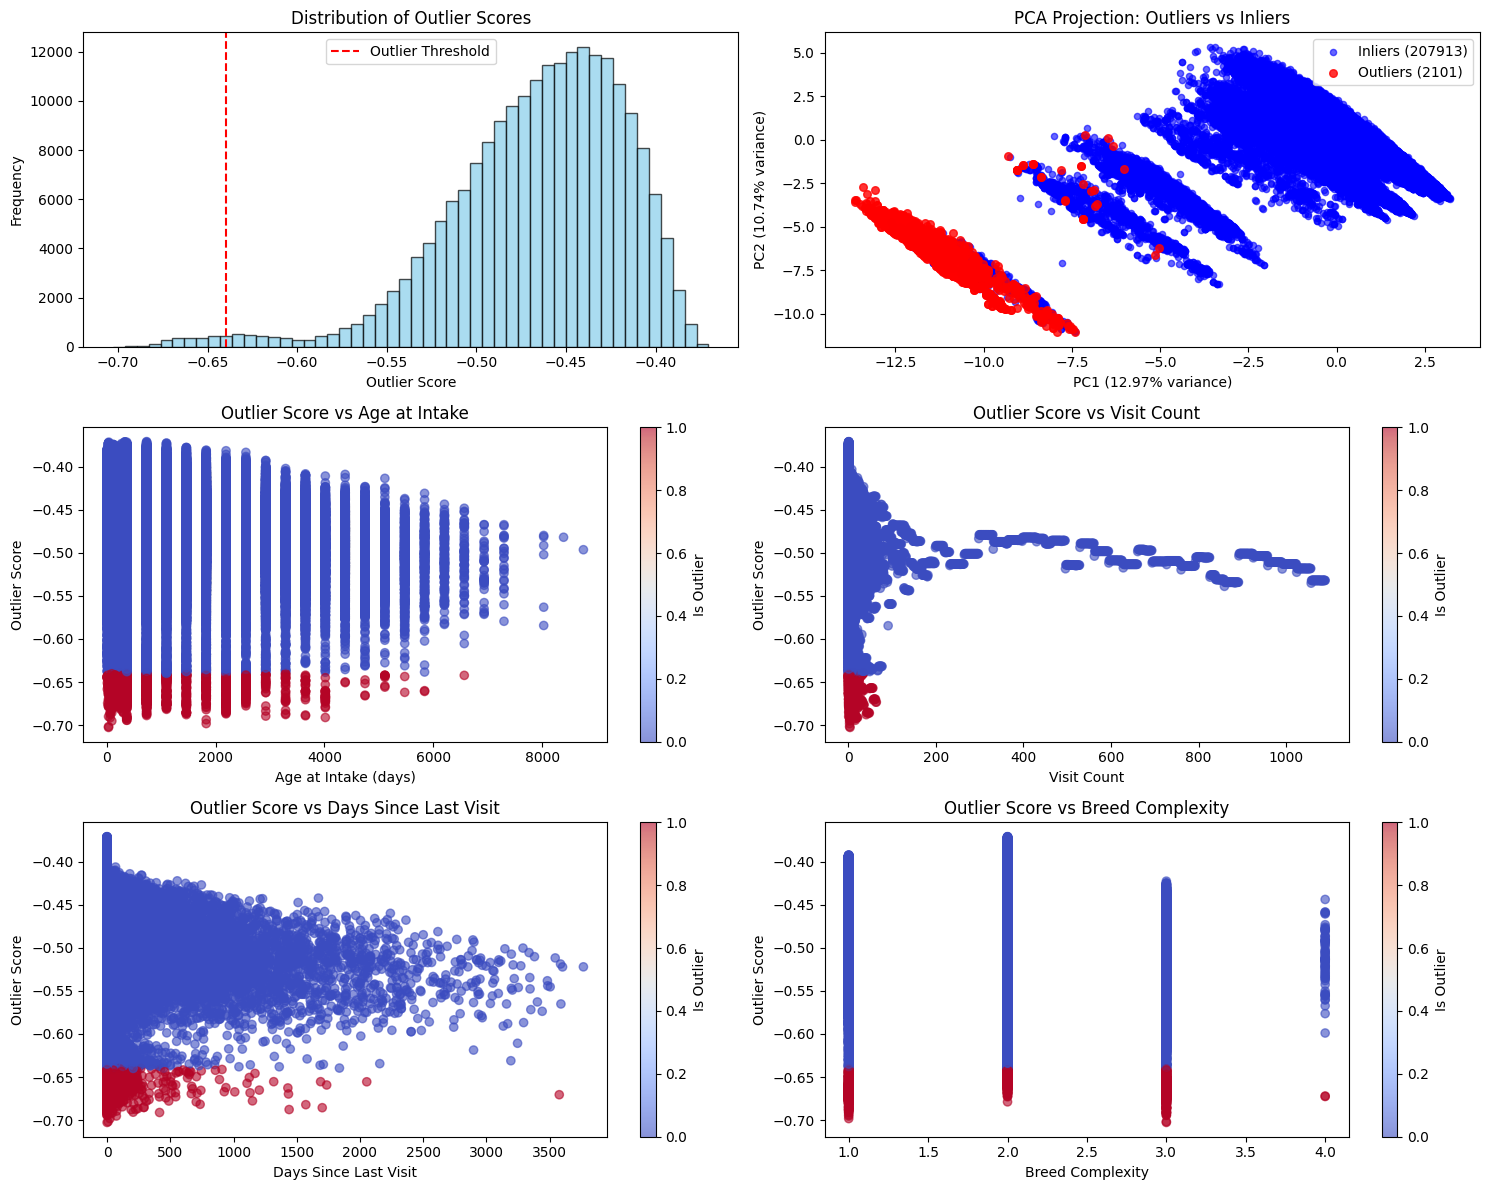


Top 10 Outliers (lowest scores):
       animal_type_intake  age_upon_intake_days  visit_count  days_since_last_visit  breed_complexity intake_condition size_category  outlier_score
26562                 Dog                  30.0            4                    0.0                 3           Normal         Large      -0.702789
26561                 Dog                  30.0            3                    8.0                 3           Normal         Large      -0.701839
161604                Cat                1825.0            3                   23.0                 1           Normal        Medium      -0.698300
218719                Cat                  90.0            3                   73.0                 1           Normal        Medium      -0.695313
101482                Dog                 365.0           16                    0.0                 3           Normal        Medium      -0.694463
27659                 Dog                 365.0            4                  

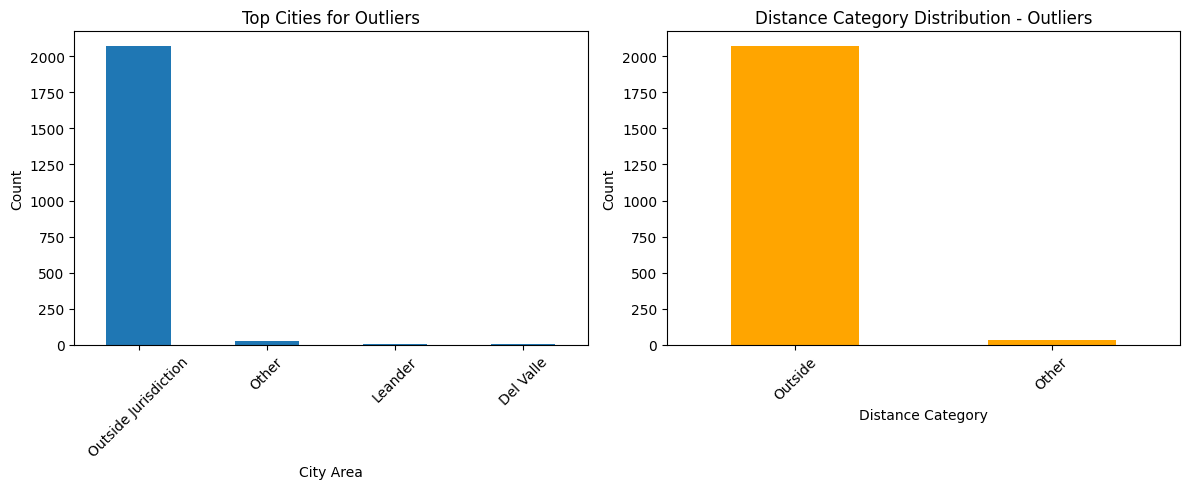

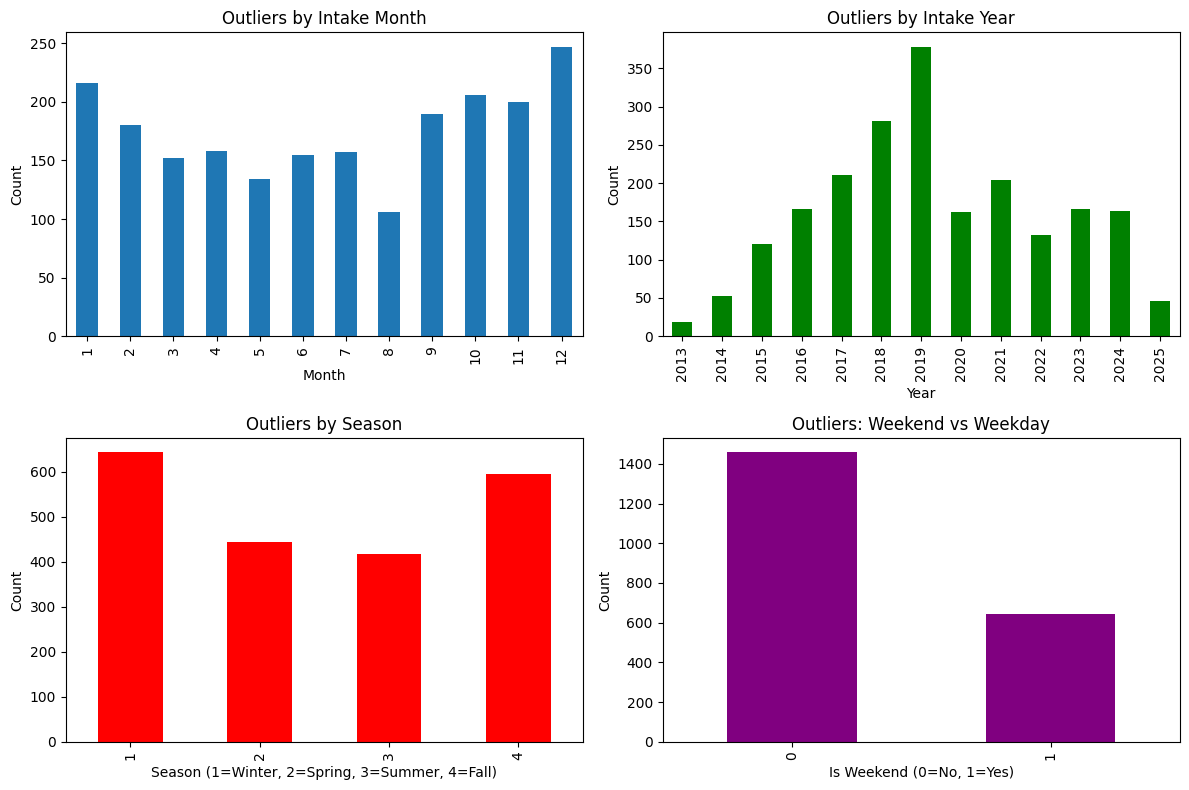


Isolation Forest analysis completed!
Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns
Most extreme outliers likely represent data entry errors or very unusual cases


In [85]:
# Define categorical variables for encoding (using Austin dataset columns)
categorical_columns = ['intake_type', 'intake_condition', 'animal_type_intake', 
                      'sex_upon_intake', 'size_category', 'primary_breed',
                      'jurisdiction', 'city_area', 'distance_category', 
                      'previous_outcome_type']

# Label encode categorical variables
label_encoders = {}
df_encoded = combined_df.copy()  # Using your combined_df from Austin analysis

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Define feature columns for Austin dataset
feature_columns = [
    # Encoded categorical features
    'intake_type_encoded', 'intake_condition_encoded', 'animal_type_intake_encoded',
    'sex_upon_intake_encoded', 'size_category_encoded', 'primary_breed_encoded',
    'jurisdiction_encoded', 'city_area_encoded', 'distance_category_encoded',
    'previous_outcome_type_encoded',
    
    # Numerical features
    'age_upon_intake_days', 'num_breeds', 'breed_complexity', 'has_name',
    'visit_count', 'is_return_visit', 'is_frequent_returner', 'days_since_last_visit',
    'month_intake', 'intake_year', 'intake_day', 'intake_dayofweek',
    'birth_year', 'birth_month', 'intake_season', 'intake_is_weekend',
    
    # Boolean features (converted to int)
    'is_mixed', 'is_working', 'is_sporting', 'is_terrier', 'is_popular_dog',
    'is_popular_cat', 'is_exotic', 'is_austin_metro', 'is_surrounding_area',
    'is_outside_jurisdiction', 'is_core_austin', 'is_travis_county'
]

# Create feature matrix
X = df_encoded[feature_columns].copy()

# Convert boolean columns to int
boolean_columns = ['is_mixed', 'is_working', 'is_sporting', 'is_terrier', 
                  'is_popular_dog', 'is_popular_cat', 'is_exotic', 'is_austin_metro',
                  'is_surrounding_area', 'is_outside_jurisdiction', 'is_core_austin', 
                  'is_travis_county']

for col in boolean_columns:
    X[col] = X[col].astype(int)

print("Feature matrix shape:", X.shape)
print("Features used:", len(feature_columns))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest
isolation_forest = IsolationForest(
    contamination=0.01,  # Expect 1% outliers
    random_state=42,
    n_estimators=100
)

# Fit and predict
outlier_labels = isolation_forest.fit_predict(X_scaled)
outlier_scores = isolation_forest.score_samples(X_scaled)

# Add results to dataframe
df_encoded['outlier_label'] = outlier_labels
df_encoded['outlier_score'] = outlier_scores
df_encoded['is_outlier'] = (outlier_labels == -1)

# Print results summary
n_outliers = sum(outlier_labels == -1)
n_inliers = sum(outlier_labels == 1)
outlier_percentage = (n_outliers / len(df_encoded)) * 100

print(f"\nIsolation Forest Results:")
print(f"Total samples: {len(df_encoded)}")
print(f"Outliers detected: {n_outliers} ({outlier_percentage:.2f}%)")
print(f"Inliers: {n_inliers} ({100-outlier_percentage:.2f}%)")

# Visualization 1: Outlier Score Distribution
plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
plt.hist(outlier_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=outlier_scores[outlier_labels == -1].max(), color='red', 
           linestyle='--', label=f'Outlier Threshold')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.legend()

# Visualization 2: PCA projection for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.subplot(3, 2, 2)
inlier_mask = outlier_labels == 1
outlier_mask = outlier_labels == -1

plt.scatter(X_pca[inlier_mask, 0], X_pca[inlier_mask, 1], 
           c='blue', alpha=0.6, s=20, label=f'Inliers ({n_inliers})')
plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], 
           c='red', alpha=0.8, s=30, label=f'Outliers ({n_outliers})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Projection: Outliers vs Inliers')
plt.legend()

# Visualization 3: Outlier scores vs key features
plt.subplot(3, 2, 3)
plt.scatter(df_encoded['age_upon_intake_days'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Age at Intake (days)')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Age at Intake')
plt.colorbar(label='Is Outlier')

plt.subplot(3, 2, 4)
plt.scatter(df_encoded['visit_count'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Visit Count')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Visit Count')
plt.colorbar(label='Is Outlier')

plt.subplot(3, 2, 5)
plt.scatter(df_encoded['days_since_last_visit'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Days Since Last Visit')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Days Since Last Visit')
plt.colorbar(label='Is Outlier')

plt.subplot(3, 2, 6)
plt.scatter(df_encoded['breed_complexity'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Breed Complexity')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Breed Complexity')
plt.colorbar(label='Is Outlier')

plt.tight_layout()
plt.show()

# Additional analysis: Top outliers
print("\nTop 10 Outliers (lowest scores):")
outlier_analysis_cols = ['animal_type_intake', 'age_upon_intake_days', 'visit_count',
                        'days_since_last_visit', 'breed_complexity', 'intake_condition',
                        'size_category', 'outlier_score']
top_outliers = df_encoded[df_encoded['is_outlier']].nsmallest(10, 'outlier_score')
print(top_outliers[outlier_analysis_cols].to_string())

# Feature importance analysis (based on outlier characteristics)
print("\nOutlier vs Inlier Comparison (mean values):")
comparison_features = ['age_upon_intake_days', 'visit_count', 'days_since_last_visit',
                      'is_frequent_returner', 'breed_complexity', 'num_breeds',
                      'has_name', 'intake_year', 'month_intake']

outlier_means = df_encoded[df_encoded['is_outlier']][comparison_features].mean()
inlier_means = df_encoded[~df_encoded['is_outlier']][comparison_features].mean()

comparison_df = pd.DataFrame({
    'Outliers': outlier_means,
    'Inliers': inlier_means,
    'Difference': outlier_means - inlier_means,
    'Ratio': outlier_means / inlier_means
})
print(comparison_df.round(3))

# Categorical feature analysis for outliers
print("\nCategorical Feature Distribution in Outliers:")
categorical_analysis = ['animal_type_intake', 'intake_type', 'intake_condition', 
                       'size_category', 'distance_category']

for feature in categorical_analysis:
    print(f"\n{feature} distribution in outliers:")
    outlier_dist = df_encoded[df_encoded['is_outlier']][feature].value_counts(normalize=True).head()
    total_dist = df_encoded[feature].value_counts(normalize=True).head()
    
    comparison_cat = pd.DataFrame({
        'Outliers (%)': (outlier_dist * 100).round(1),
        'Overall (%)': (total_dist * 100).round(1)
    })
    print(comparison_cat)

# Adoption outcome analysis for outliers
print("\nAdoption Outcome Analysis:")
outlier_adoption_rate = df_encoded[df_encoded['is_outlier']]['Is_adopted'].mean()
inlier_adoption_rate = df_encoded[~df_encoded['is_outlier']]['Is_adopted'].mean()
overall_adoption_rate = df_encoded['Is_adopted'].mean()

print(f"Adoption rate among outliers: {outlier_adoption_rate:.3f} ({outlier_adoption_rate*100:.1f}%)")
print(f"Adoption rate among inliers: {inlier_adoption_rate:.3f} ({inlier_adoption_rate*100:.1f}%)")
print(f"Overall adoption rate: {overall_adoption_rate:.3f} ({overall_adoption_rate*100:.1f}%)")

# Geographic analysis (city/jurisdiction outliers)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
outlier_cities = df_encoded[df_encoded['is_outlier']]['city_area'].value_counts().head(10)
outlier_cities.plot(kind='bar')
plt.title('Top Cities for Outliers')
plt.xlabel('City Area')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
outlier_distance = df_encoded[df_encoded['is_outlier']]['distance_category'].value_counts()
outlier_distance.plot(kind='bar', color='orange')
plt.title('Distance Category Distribution - Outliers')
plt.xlabel('Distance Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Time-based outlier analysis
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
monthly_outliers = df_encoded[df_encoded['is_outlier']]['month_intake'].value_counts().sort_index()
monthly_outliers.plot(kind='bar')
plt.title('Outliers by Intake Month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
yearly_outliers = df_encoded[df_encoded['is_outlier']]['intake_year'].value_counts().sort_index()
yearly_outliers.plot(kind='bar', color='green')
plt.title('Outliers by Intake Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
seasonal_outliers = df_encoded[df_encoded['is_outlier']]['intake_season'].value_counts().sort_index()
seasonal_outliers.plot(kind='bar', color='red')
plt.title('Outliers by Season')
plt.xlabel('Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
weekend_outliers = df_encoded[df_encoded['is_outlier']]['intake_is_weekend'].value_counts()
weekend_outliers.plot(kind='bar', color='purple')
plt.title('Outliers: Weekend vs Weekday')
plt.xlabel('Is Weekend (0=No, 1=Yes)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\nIsolation Forest analysis completed!")
print(f"Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns")
print(f"Most extreme outliers likely represent data entry errors or very unusual cases")

# ML Model

## Correlation matrix

In [ ]:
# Select only numerical columns
numerical_cols = combined_df.select_dtypes(include=[np.number]).columns

# Create correlation matrix
correlation_matrix = combined_df[numerical_cols].corr()

# Create the correlation plot
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})

plt.title('Correlation Matrix of Numerical Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
combined_df.info()

## H20 automl run 1

In [ ]:
# H2O AutoML Modeling

# Initialize H2O
h2o.init()

"""## Data Preparation for H2O"""

# Create a copy for modeling
model_data = combined_df.copy()

# Convert categorical columns to strings for H2O
categorical_cols = ['animal_type_intake', 'sex_upon_intake', 'intake_type', 'intake_condition',
                   'size_category', 'distance_category', 'primary_breed', 'city_area', 
                   'jurisdiction', 'previous_outcome_type']

for col in categorical_cols:
    if col in model_data.columns:
        model_data[col] = model_data[col].astype(str)

# Convert to H2O Frame
h2o_data = h2o.H2OFrame(model_data)

# Set categorical columns
for col in categorical_cols:
    if col in h2o_data.columns:
        h2o_data[col] = h2o_data[col].asfactor()

# Set target as factor for classification
h2o_data['Is_adopted'] = h2o_data['Is_adopted'].asfactor()

"""## Train-Test Split"""

train, test = h2o_data.split_frame(ratios=[0.8], seed=42)

# Define features and target
target = 'Is_adopted'
features = [col for col in h2o_data.columns if col != target]

print(f"Training set: {train.nrows} rows")
print(f"Test set: {test.nrows} rows")
print(f"Features: {len(features)}")

"""## H2O AutoML with Specified Algorithms"""

# Define the algorithms we want to include (using correct H2O names)
include_algos = ["XGBoost", "GBM", "DRF", "StackedEnsemble"]

# Run AutoML
aml = H2OAutoML(
    max_models=50,  # Increase for more hyperparameter combinations
    max_runtime_secs=14400,  # 1 hour max runtime
    include_algos=include_algos,
    seed=42,
    balance_classes=True,  # Handle class imbalance
    sort_metric="AUC"
)

# Train the models
aml.train(x=features, y=target, training_frame=train, validation_frame=test)

In [ ]:
"""## Model Performance Evaluation"""

# View the leaderboard
lb = aml.leaderboard
print("AutoML Leaderboard:")
print(lb.head(rows=10))

# Get the best model
best_model = aml.leader


In [ ]:
# Performance on test set
test_performance = best_model.model_performance(test)
print("\nBest Model Performance on Test Set:")
print(f"AUC: {test_performance.auc():.4f}")
print(f"Accuracy: {test_performance.accuracy()[0][0]:.4f}")
print(f"Precision: {test_performance.precision()[0][0]:.4f}")
print(f"Recall: {test_performance.recall()[0][0]:.4f}")
print(f"F1 Score: {test_performance.F1()[0][0]:.4f}")

# Confusion Matrix
cm = test_performance.confusion_matrix()
print("\nConfusion Matrix:")
print(cm)

In [ ]:
h2o.cluster().shutdown()

In [ ]:
# Get confusion matrix at 0.5 threshold
cm_05 = test_performance.confusion_matrix(thresholds=[0.5])
print("Confusion Matrix at 0.5 threshold:")
print(cm_05)

# Get metrics at 0.5 threshold
metrics_05 = test_performance.metric('f1', thresholds=[0.5])
print(f"F1 at 0.5 threshold: {metrics_05[0][1]:.4f}")

## Best model performance metrics

In [ ]:
# Performance metrics at 0.5 threshold
cm_05 = test_performance.confusion_matrix(thresholds=[0.5])
print("Confusion Matrix at 0.5 threshold:")
print(cm_05)

# Extract key metrics at 0.5 threshold
f1_05 = test_performance.metric('f1', thresholds=[0.5])[0][1]
precision_05 = test_performance.metric('precision', thresholds=[0.5])[0][1] 
recall_05 = test_performance.metric('recall', thresholds=[0.5])[0][1]
accuracy_05 = test_performance.metric('accuracy', thresholds=[0.5])[0][1]

print(f"\nMetrics at 0.5 threshold:")
print(f"Accuracy: {accuracy_05:.4f}")
print(f"Precision: {precision_05:.4f}")
print(f"Recall: {recall_05:.4f}")
print(f"F1 Score: {f1_05:.4f}")

## Saving model hyperparameters

In [ ]:
# 1. Get best model
best_model = aml.leader
print(f"Best Model: {best_model.model_id}")
print(f"Algorithm: {best_model.algo}")

# 2. Get hyperparameters
print("\nHyperparameters:")
params = best_model.params
for key, value in params.items():
   if value['actual'] is not None:
       print(f"{key}: {value['actual']}")

# For ensemble, show base models
if "StackedEnsemble" in best_model.model_id:
   print(f"\nBase models:")
   for model in best_model.params['base_models']['actual']:
       print(f"- {model}")

# 3. Save model (H2O format - pickle won't work for H2O models)
model_path = h2o.save_model(best_model, path="./", force=True)
print(f"\nModel saved to: {model_path}")



In [ ]:
# For FastAPI, you'll need to convert to MOJO or use H2O server
# Save as MOJO (better for production)
mojo_path = best_model.download_mojo(path="./", get_genmodel_jar=True)
print(f"MOJO saved to: {mojo_path}")

In [ ]:
h2o.cluster().shutdown()

In [ ]:
combined_df.info()

# Insights from ML Model

## Feature importance

In [71]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,44 mins 53 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 26 days
H2O_cluster_name:,H2O_from_python_atharvavyas_1oetfp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.237 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [72]:
# Load saved H2O model
model = h2o.load_model("/Users/atharvavyas/Desktop/McGill Academics/Community Capstone/StackedEnsemble_AllModels_1_AutoML_1_20250720_170401")

First base model: GBM_grid_1_AutoML_1_20250720_170401_model_11
Feature Importance:
                 variable  relative_importance  scaled_importance  percentage
0    age_upon_intake_days         13071.222656           1.000000    0.101608
1             intake_type         12388.120117           0.947740    0.096298
2           date_of_birth         11890.456055           0.909667    0.092429
3              intake_day          9392.779297           0.718585    0.073014
4         sex_upon_intake          8253.895508           0.631456    0.064161
5             birth_month          7947.915527           0.608047    0.061782
6           primary_breed          6832.417480           0.522707    0.053111
7   previous_outcome_type          6437.587402           0.492501    0.050042
8        intake_dayofweek          5978.248535           0.457360    0.046471
9              birth_year          5631.656738           0.430844    0.043777
10               has_name          5150.702637           0.

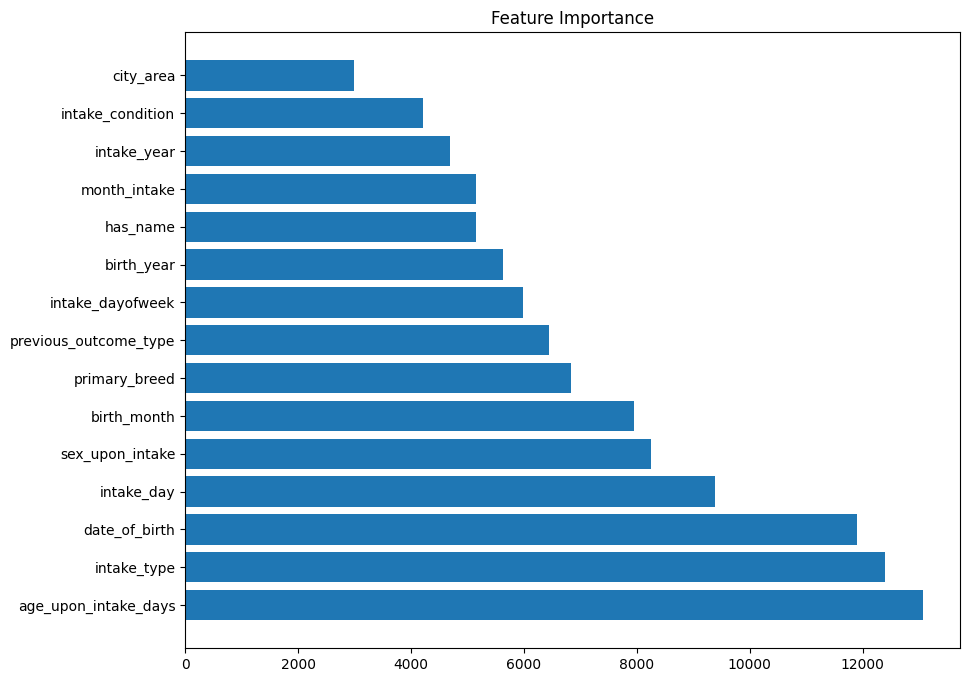

In [73]:
# Get base model names correctly
base_models = model.params['base_models']['actual']
base_model_name = base_models[0]['name']
print("First base model:", base_model_name)

# Get the model
base_model = h2o.get_model(base_model_name)
var_imp = base_model.varimp(use_pandas=True)
print("Feature Importance:")
print(var_imp.head(15))

# Plot
plt.figure(figsize=(10, 8))
top_15 = var_imp.head(15)
plt.barh(top_15['variable'], top_15['relative_importance'])
plt.title('Feature Importance')
plt.show()

## SHAPley additive explanations

In [74]:
# Create a copy for modeling
model_data = combined_df.copy()

# Convert categorical columns to strings for H2O
categorical_cols = ['animal_type_intake', 'sex_upon_intake', 'intake_type', 'intake_condition',
                   'size_category', 'distance_category', 'primary_breed', 'city_area', 
                   'jurisdiction', 'previous_outcome_type']

for col in categorical_cols:
    if col in model_data.columns:
        model_data[col] = model_data[col].astype(str)

# Convert to H2O Frame
h2o_data = h2o.H2OFrame(model_data)

# Set categorical columns
for col in categorical_cols:
    if col in h2o_data.columns:
        h2o_data[col] = h2o_data[col].asfactor()

# Set target as factor for classification
h2o_data['Is_adopted'] = h2o_data['Is_adopted'].asfactor()

"""## Train-Test Split"""

train, test = h2o_data.split_frame(ratios=[0.8], seed=42)

# Define features and target
target = 'Is_adopted'
features = [col for col in h2o_data.columns if col != target]

print(f"Training set: {train.nrows} rows")
print(f"Test set: {test.nrows} rows")
print(f"Features: {len(features)}")


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set: 168026 rows
Test set: 41988 rows
Features: 39


[LightGBM] [Info] Number of positive: 85664, number of negative: 82362
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 168026, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509826 -> initscore=0.039309
[LightGBM] [Info] Start training from score 0.039309


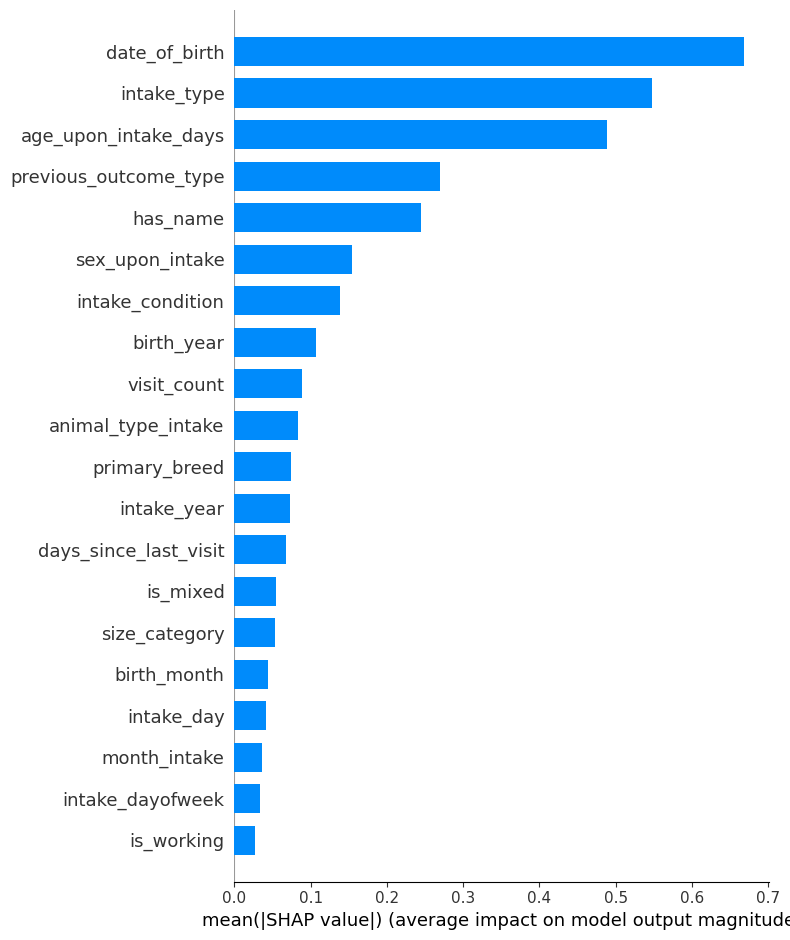

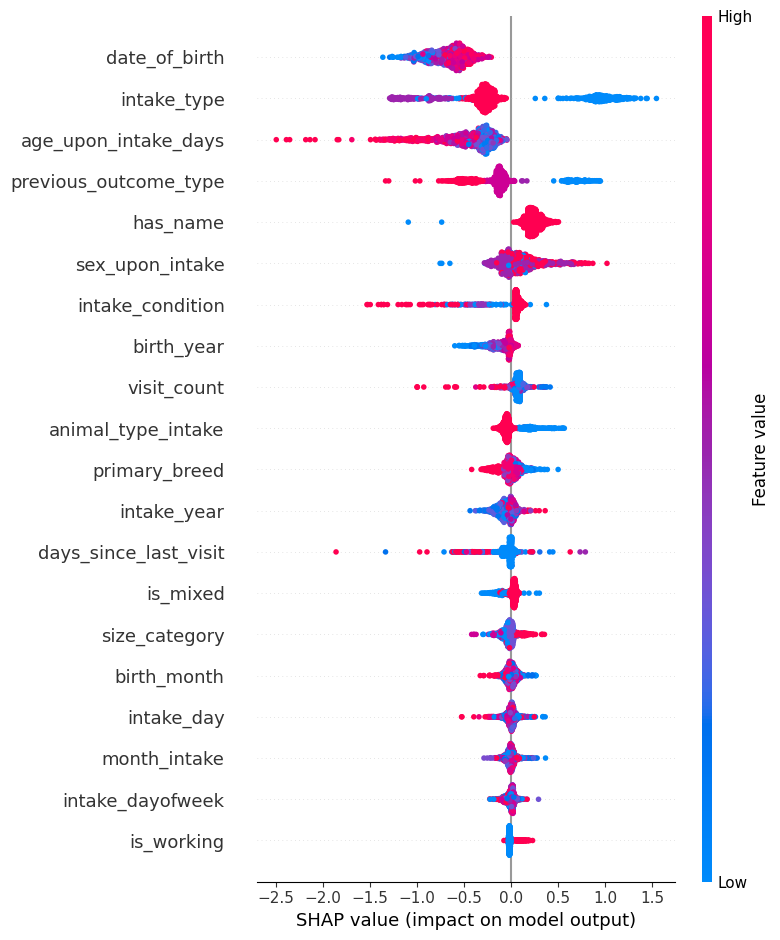

SHAP vs H2O Feature Ranking:
                 variable  relative_importance                feature  \
0    age_upon_intake_days         13071.222656   age_upon_intake_days   
1                     NaN                  NaN     animal_type_intake   
2             birth_month          7947.915527                    NaN   
3              birth_year          5631.656738             birth_year   
4           date_of_birth         11890.456055          date_of_birth   
5                     NaN                  NaN               has_name   
6                     NaN                  NaN       intake_condition   
7              intake_day          9392.779297                    NaN   
8        intake_dayofweek          5978.248535                    NaN   
9             intake_type         12388.120117            intake_type   
10  previous_outcome_type          6437.587402  previous_outcome_type   
11          primary_breed          6832.417480                    NaN   
12        sex_upon_int

In [76]:
# Get training data for SHAP
train_df = train.as_data_frame()
X_train = train_df.drop(['Is_adopted'], axis=1)
y_train = train_df['Is_adopted']

# Encode categoricals
X_encoded = X_train.copy()
categorical_cols = ['animal_type_intake', 'sex_upon_intake', 'intake_type', 
                   'intake_condition', 'size_category', 'primary_breed',
                   'distance_category', 'previous_outcome_type', 'city_area', 'jurisdiction']

for col in categorical_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Train surrogate model
lgb_model = lgb.LGBMClassifier(n_estimators=500, random_state=42)
lgb_model.fit(X_encoded, y_train)

# SHAP analysis
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_encoded[:1000])

# SHAP visualizations - don't index for binary classification
shap.summary_plot(shap_values, X_encoded[:1000], plot_type="bar")
shap.summary_plot(shap_values, X_encoded[:1000])

# Feature importance comparison
shap_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'shap_importance': np.abs(shap_values).mean(0)
}).sort_values('shap_importance', ascending=False)

print("SHAP vs H2O Feature Ranking:")
comparison = pd.merge(
    var_imp.head(10)[['variable', 'relative_importance']], 
    shap_importance.head(10), 
    left_on='variable', right_on='feature', how='outer'
)
print(comparison)